# Projet 9

# 1. Télécharger et "standardiser" les données

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('P9_df_final.csv')
df.head(2)

,Zone,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Population,Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
0,Afghanistan,5.63,-2.73,361.601822,37171921.0,57.0,0.0,29.0,28.0
1,Angola,9.23,-0.52,3418.133219,30809787.0,319.0,0.0,277.0,42.0


In [3]:
# Comme vu dans le notebook sur les data, on isole la variable population pour éviter les outliers
population = df['Population']

In [4]:
df.drop('Population', axis=1, inplace=True)

In [5]:
df.head(2)

,Zone,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
0,Afghanistan,5.63,-2.73,361.601822,57.0,0.0,29.0,28.0
1,Angola,9.23,-0.52,3418.133219,319.0,0.0,277.0,42.0


In [6]:
df.shape

(165, 8)

In [7]:
# On isole les noms des pays dans une variable "name"
names = df.Zone.values
names[:10]

array(['Afghanistan', 'Angola', 'Albanie', 'Émirats arabes unis',
       'Argentine', 'Arménie', 'Antigua-et-Barbuda', 'Australie',
       'Autriche', 'Azerbaïdjan'], dtype=object)

In [8]:
# On défini la matrice X de laquelle on supprime les pays.

X = df.drop(columns='Zone').values
X[:10]

array([[ 5.63000000e+00, -2.73000000e+00,  3.61601822e+02,
         5.70000000e+01,  0.00000000e+00,  2.90000000e+01,
         2.80000000e+01],
       [ 9.23000000e+00, -5.20000000e-01,  3.41813322e+03,
         3.19000000e+02,  0.00000000e+00,  2.77000000e+02,
         4.20000000e+01],
       [ 1.10000000e+00,  8.00000000e-02,  6.40838934e+03,
         4.70000000e+01,  0.00000000e+00,  3.80000000e+01,
         1.30000000e+01],
       [ 3.28000000e+00,  6.30000000e-01,  5.33742168e+04,
         4.12000000e+02,  9.40000000e+01,  4.33000000e+02,
         4.80000000e+01],
       [ 6.88000000e+00,  4.00000000e-02,  1.37533864e+04,
         1.96200000e+03,  2.07000000e+02,  8.00000000e+00,
         2.16100000e+03],
       [ 3.11000000e+00, -5.70000000e-01,  6.63549606e+03,
         4.70000000e+01,  0.00000000e+00,  3.50000000e+01,
         1.10000000e+01],
       [ 1.30700000e+01,  9.30000000e-01,  1.80399676e+04,
         7.00000000e+00,  0.00000000e+00,  7.00000000e+00,
         0.0000000

In [9]:
# On scale nos données
# On instancie et on entraine notre scaler:

std_scale = preprocessing.StandardScaler()
std_scale.fit(X)

StandardScaler()

In [10]:
# On transforme les données:

X_scaled = std_scale.transform(X)
X_scaled[:10]

array([[ 0.03430047, -2.92042593, -0.71853401, -0.29237348, -0.2320702 ,
        -0.32921134, -0.28084773],
       [ 0.83251711, -0.47881433, -0.57871975, -0.17387258, -0.2320702 ,
         0.98699073, -0.27528176],
       [-0.97012213,  0.18406665, -0.44193711, -0.29689641, -0.2320702 ,
        -0.28144595, -0.28681127],
       [-0.48675761,  0.79170754,  1.70641067, -0.13180929, -0.03027568,
         1.81492429, -0.27289635],
       [ 0.31145903,  0.13987458, -0.10595648,  0.56924562,  0.21230709,
        -0.44066394,  0.56716747],
       [-0.52445118, -0.53405441, -0.43154861, -0.29689641, -0.2320702 ,
        -0.29736775, -0.28760641],
       [ 1.68394819,  1.12314803,  0.09012369, -0.31498815, -0.2320702 ,
        -0.44597121, -0.29197967],
       [-1.0565956 ,  1.0347639 ,  2.21584593,  0.21148147, -0.14190669,
        -0.39820581,  0.2125357 ],
       [-0.88586593,  1.0347639 ,  1.64773295, -0.23990743, -0.06462369,
         0.10067724, -0.23313942],
       [ 0.10081852, -0.7108

In [11]:
# Grace à la méthode describe, on confirme que la moyenne est à 0 et l'écart-type à 1:

pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]

,0,1,2,3,4,5,6
mean,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# 2. Clustering

## 2.1 Classification hiérarchique et dendrogramme: 

In [12]:
# Nous allons calculer les distances entre les points/clusters en spécifiant la méthode à utiliser (les méthodes de lien=linkage
    # methods)ce sont ces distances qui permettent de lier les clusters lorsque l'on construit petit à petit l'arborescence).
# Plus la distance est grande, plus il y a de clusters.(la distance sera représentée sur l'axe des y)
# Méthode retenue: Méthode de Ward: permet de garantir que les clusters sont bien séparés tout en garantissant qu'ils soient 
    # resserrés sur eux-mêmes ( cherche à minimiser l'augmentation d'inertie intraclasse due au regroupement des 2 clusters).

Z = linkage(X_scaled, method="ward")
Z[:11]

array([[4.50000000e+01, 1.34000000e+02, 4.56469893e-02, 2.00000000e+00],
       [7.90000000e+01, 1.03000000e+02, 8.94802991e-02, 2.00000000e+00],
       [3.20000000e+01, 1.54000000e+02, 1.18358117e-01, 2.00000000e+00],
       [5.40000000e+01, 1.01000000e+02, 1.43029174e-01, 2.00000000e+00],
       [2.00000000e+00, 9.40000000e+01, 1.44703308e-01, 2.00000000e+00],
       [5.00000000e+00, 1.60000000e+01, 1.63454293e-01, 2.00000000e+00],
       [1.30000000e+01, 1.38000000e+02, 1.65540558e-01, 2.00000000e+00],
       [8.70000000e+01, 1.64000000e+02, 1.76293549e-01, 2.00000000e+00],
       [1.29000000e+02, 1.36000000e+02, 1.81861008e-01, 2.00000000e+00],
       [4.60000000e+01, 1.07000000e+02, 1.91574167e-01, 2.00000000e+00],
       [8.50000000e+01, 1.51000000e+02, 1.97523331e-01, 2.00000000e+00]])

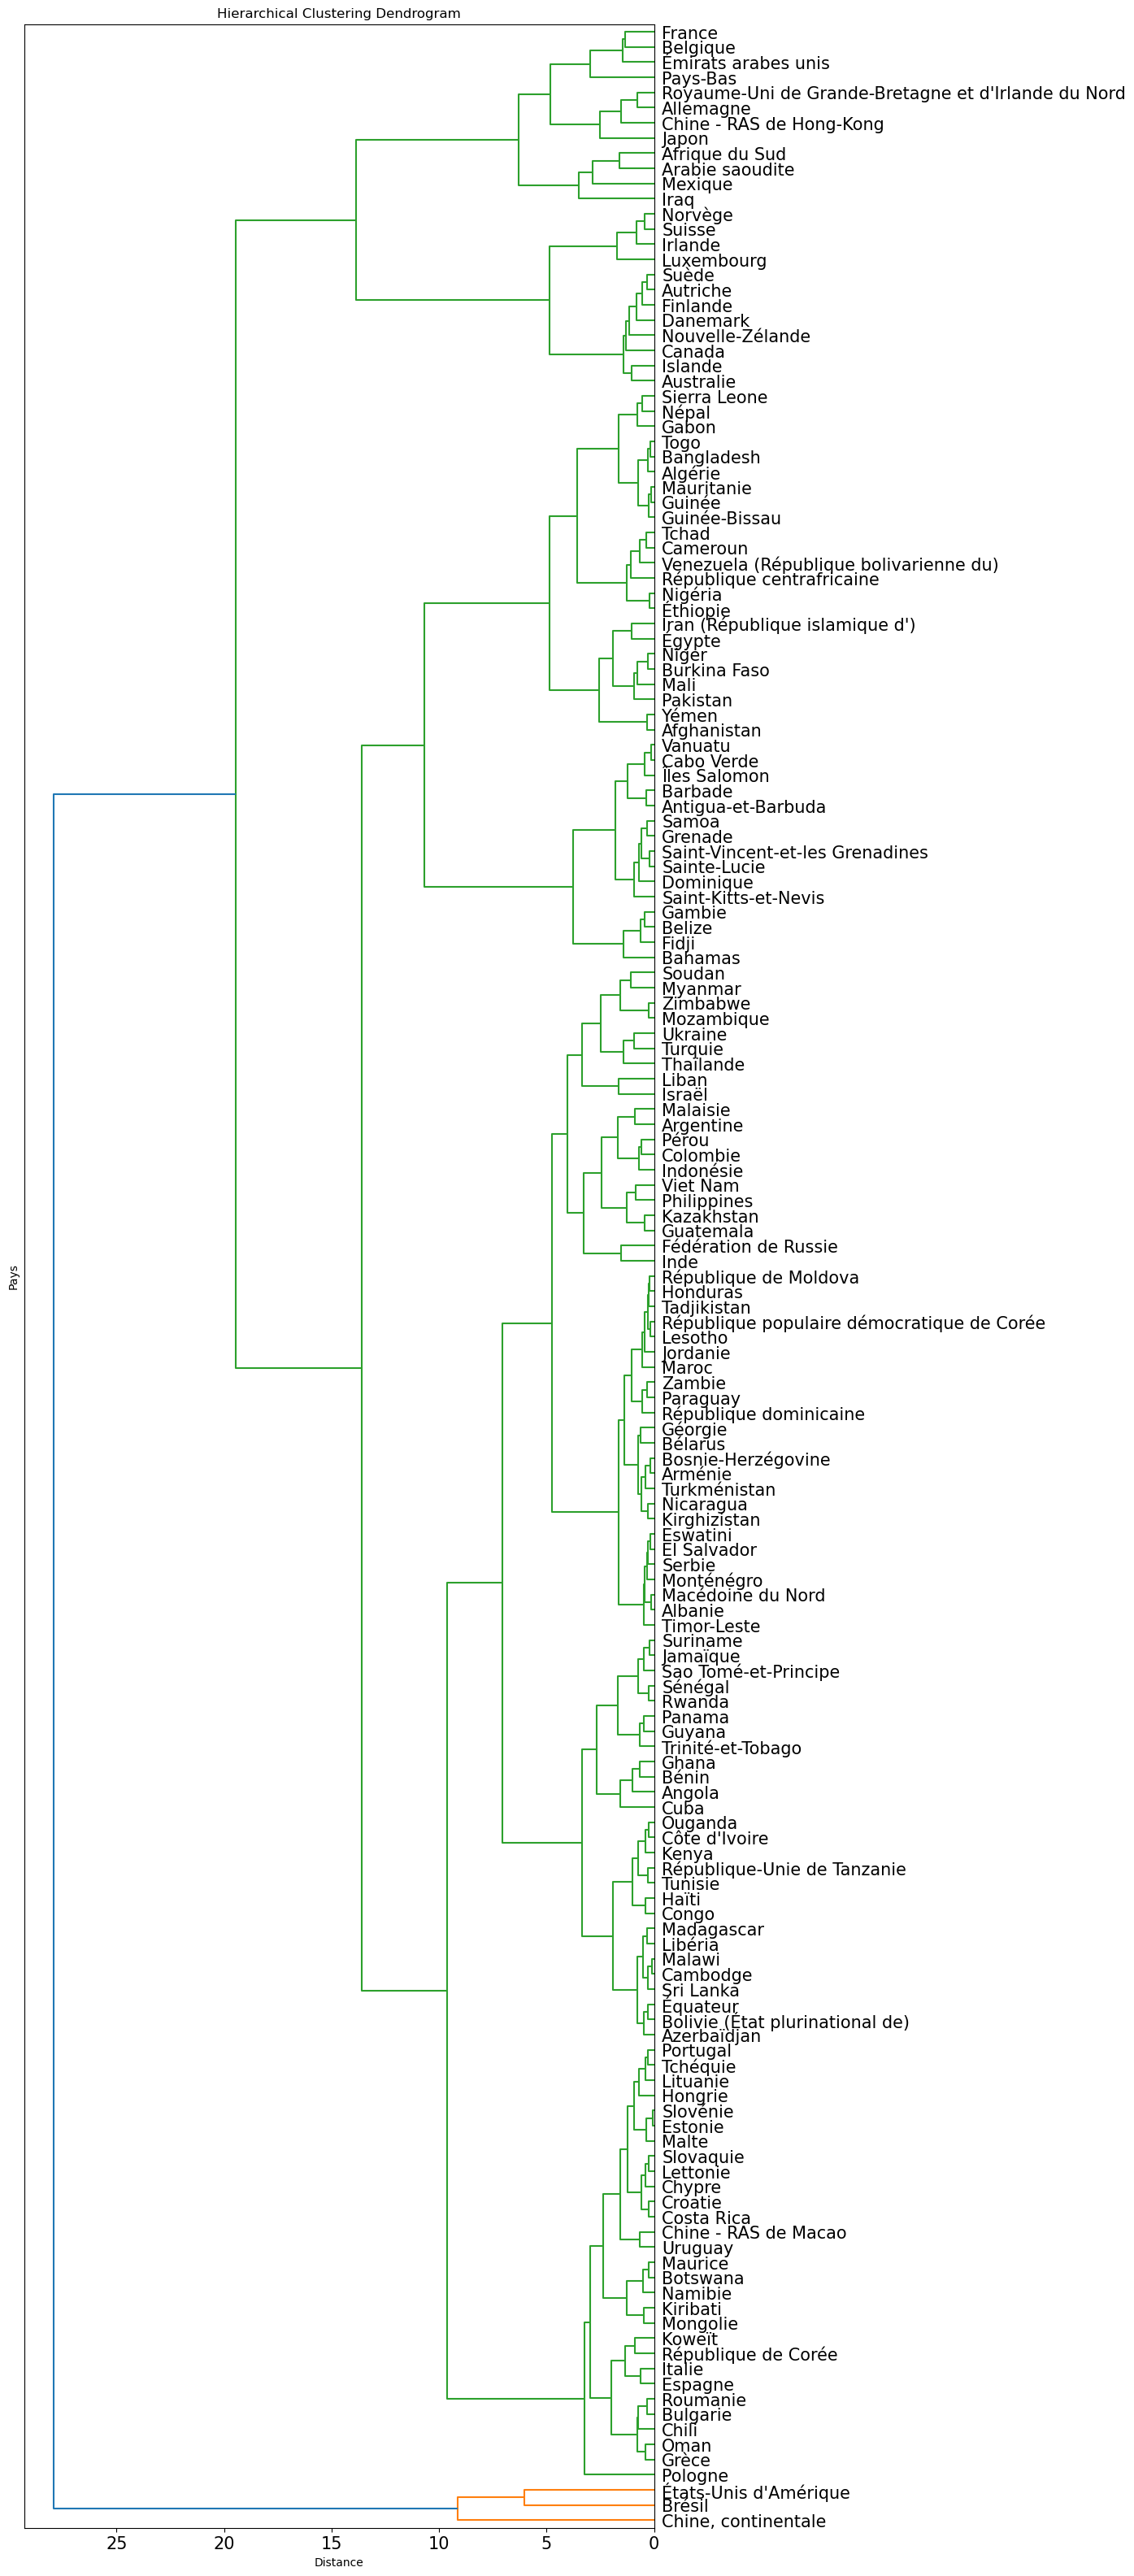

In [13]:
# Afficher le dendrogramme : 

fig, ax = plt.subplots(1, 1, figsize=(10,40))

_ = dendrogram(Z, ax=ax, labels=names, orientation = "left")

plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)


In [14]:
# Ensuite, on défini le nombre de clusters que l'on souhaite:
k=3

# On aurait pu choisir entre 3 et 5 clusters, l'idée est donc de voir ce qu'apporte de plus le fait de passer de 3 à 5
    # On a testé pour comparer on déciderait dans les deux cas de garder le même groupe de pays qui serait assez identique, 
    # on retient donc un découpage à 3 clusters.

In [15]:
# On applique ensuite la fonction fclusters de scipy pour définir les clusters :

clusters = fcluster(Z, k, criterion='maxclust')
clusters

array([2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2], dtype=int32)

In [16]:
# On ajoute les clusters au df initial

df['clusters'] = clusters
df.head(2)

,Zone,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,clusters
0,Afghanistan,5.63,-2.73,361.601822,57.0,0.0,29.0,28.0,2
1,Angola,9.23,-0.52,3418.133219,319.0,0.0,277.0,42.0,2


In [17]:
# On groupe nos valeurs par Clusters et on demande la moyenne afin de faire une heatmap

heat_clusters = df.groupby('clusters').mean()
heat_clusters

,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
clusters,,,,,,,
1,4.133333,-0.153333,31840.265460,15469.666667,2830.333333,192.666667,18117.000000
2,6.137319,-0.198841,9036.470371,350.340580,31.442029,40.398551,351.036232
3,1.836458,0.567083,54539.726569,887.875000,208.625000,369.458333,766.000000


<AxesSubplot:title={'center':'Heatmap des clusters'}>

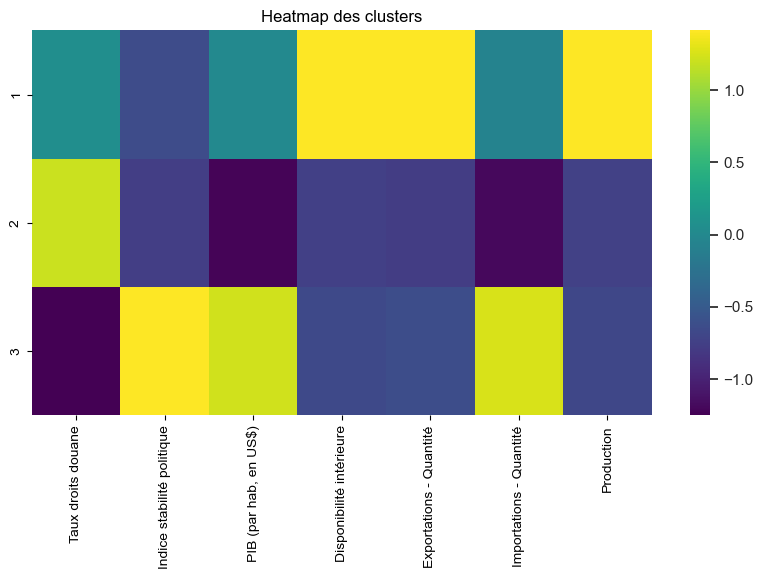

In [18]:
# On affiche la heatmap

heat_clusters_graph= StandardScaler().fit_transform(heat_clusters)
plt.figure(figsize=(10,5))
plt.title('Heatmap des clusters')
sns.set(font_scale=1)
sns.heatmap(heat_clusters_graph, cmap='viridis',xticklabels=heat_clusters.columns, yticklabels=heat_clusters.index)

# On décide de garder le Cluster 3

In [19]:
# On affiche les pays de chaque cluster pour avoir une idée des pays concernés:

C1 = df.loc[df['clusters'] == 1, :]
C1.Zone.unique()

array(['Brésil', 'Chine, continentale', "États-Unis d'Amérique"],
      dtype=object)

In [74]:
C2 = df.loc[df['clusters'] == 2, :]
C2.Zone.unique()

array(['Afghanistan', 'Angola', 'Albanie', 'Argentine', 'Arménie',
       'Antigua-et-Barbuda', 'Azerbaïdjan', 'Bénin', 'Burkina Faso',
       'Bangladesh', 'Bulgarie', 'Bahamas', 'Bosnie-Herzégovine',
       'Bélarus', 'Belize', 'Bolivie (État plurinational de)', 'Barbade',
       'Botswana', 'République centrafricaine', 'Chili', "Côte d'Ivoire",
       'Cameroun', 'Congo', 'Colombie', 'Cabo Verde', 'Costa Rica',
       'Cuba', 'Chypre', 'Tchéquie', 'Dominique',
       'République dominicaine', 'Algérie', 'Équateur', 'Égypte',
       'Espagne', 'Estonie', 'Éthiopie', 'Fidji', 'Gabon', 'Géorgie',
       'Ghana', 'Guinée', 'Gambie', 'Guinée-Bissau', 'Grèce', 'Grenade',
       'Guatemala', 'Guyana', 'Honduras', 'Croatie', 'Haïti', 'Hongrie',
       'Indonésie', 'Inde', "Iran (République islamique d')", 'Israël',
       'Italie', 'Jamaïque', 'Jordanie', 'Kazakhstan', 'Kenya',
       'Kirghizistan', 'Cambodge', 'Saint-Kitts-et-Nevis',
       'République de Corée', 'Koweït', 'Liban', 'Libér

In [21]:
C3 = df.loc[df['clusters'] == 3, :]
C3.Zone.unique()

array(['Émirats arabes unis', 'Australie', 'Autriche', 'Belgique',
       'Canada', 'Suisse', 'Allemagne', 'Danemark', 'Finlande', 'France',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
       'Chine - RAS de Hong-Kong', 'Irlande', 'Islande', 'Japon',
       'Luxembourg', 'Mexique', 'Pays-Bas', 'Norvège', 'Nouvelle-Zélande',
       'Arabie saoudite', 'Suède', 'Afrique du Sud', 'Iraq'], dtype=object)

## 2.2 K-means

In [22]:
# On instancie notre estimateur:

kmeans = KMeans(n_clusters=4, random_state=4)

In [23]:
# On l'entraine :

kmeans.fit(X_scaled)

KMeans(n_clusters=4, random_state=4)

### 2.2.1 La méthode du Coude: (pour définir le bon nombre de clusters)

In [24]:
#On défini d'abord une liste vide pour sotcker nos inerties:
intertia = []

In [25]:
#Pour choisir le nombre optimal de clusters, on lance souvent le k-means plusieurs fois, avec différentes valeurs de K:
#On défini donc la liste du nombre de clusters que l'on veut tester:(ici jusqu'à 10 Clusters)
k_list = range(1, 10) 

In [26]:
#Pour chaque valeur de K, on note l’inertie intraclasse obtenue. (l'inertie intraclasse c'est l'addition de toutes les inerties
# propres pour chaque cluster, une fois qu’on a pour chaque cluster son inertie, on prend la moyenne de ces valeurs). On 
# recherche à ce que les groupes soient le plus resserrés sur eux-même: On cherche à minimiser la variance intraclasse ).

#Pour chaque valeur de k, on entraine un k-means spécifique et on stocke son inertie :

for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_scaled) 
  intertia.append(kmeans.inertia_)

C:\Users\leuriot\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [27]:
# Nous obtenons une liste d'inerties :
# Plus il y a de clusters, plus le nombre d'individus par cluster diminue, et plus les clusters sont resserrés. 
# Donc, bien entendu, l’inertie intraclasse diminue forcément quand K augmente.

intertia

[1155.0,
 765.6590134828336,
 558.2213524502458,
 447.45765266968,
 360.7680405115513,
 299.7498938963944,
 255.78146083691567,
 218.6678793116351,
 203.56948763353486]

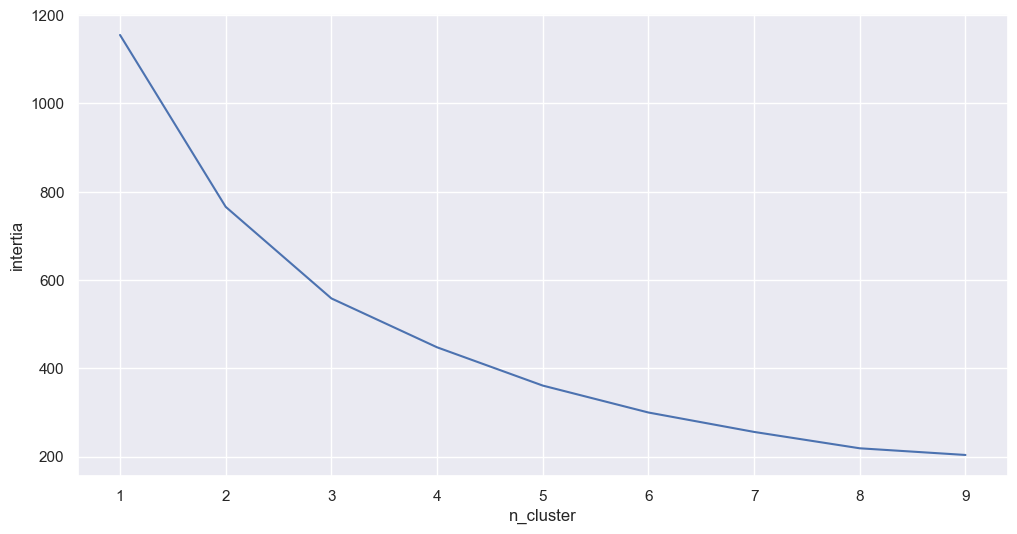

In [28]:
#Pour déterminer le nombre de clusters à étudier, on s'intéresse au graphique qui trace l'inertie intraclasse en fonction 
#du nombre de clusters. On cherche plus particulièrement une "cassure" dans la courbe. Cette "cassure" nous indique à partir 
#de quel nombre de clusters nous "allons trop loin".

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax = plt.plot(k_list, intertia)

# On pourrait choisir ici entre 2 ou 3 clusters. On en choisi 3.

### 2.2.2 Définir nos clusters: 

In [29]:
# Nous devons d'abord ré-entrainer un estimateur:

kmeans = KMeans(n_clusters=3, random_state =4)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=4)

In [30]:
# Les clusters obtenus:

clusters_kmeans = kmeans.labels_

In [31]:
# On ajoute les clusters au df:

df["clusters_kmean"] = clusters_kmeans
df

,Zone,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,clusters,clusters_kmean
0,Afghanistan,5.630,-2.73,361.601822,57.0,0.0,29.0,28.0,2,0
1,Angola,9.230,-0.52,3418.133219,319.0,0.0,277.0,42.0,2,0
2,Albanie,1.100,0.08,6408.389337,47.0,0.0,38.0,13.0,2,0
3,Émirats arabes unis,3.280,0.63,53374.216781,412.0,94.0,433.0,48.0,3,2
4,Argentine,6.880,0.04,13753.386382,1962.0,207.0,8.0,2161.0,2,0
...,...,...,...,...,...,...,...,...,...,...
160,Chine - RAS de Macao,3.915,1.15,33530.044263,19.0,0.0,23.0,3.0,2,2
161,Iraq,3.915,-2.53,6355.560152,566.0,0.0,470.0,96.0,3,0
162,Kiribati,3.915,1.08,1543.401478,2.0,0.0,1.0,1.0,2,0
163,République de Moldova,3.915,-0.42,4497.155765,66.0,0.0,16.0,54.0,2,0


In [32]:
# On groupe nos valeurs par Clusters et on demande la moyenne afin de faire une heatmap

heat_clusters_kmeans = df.groupby('clusters_kmean').mean()
heat_clusters_kmeans.drop('clusters', axis=1, inplace=True)
heat_clusters_kmeans

,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
clusters_kmean,,,,,,,
0,7.202252,-0.413514,5399.185908,353.540541,19.486486,35.738739,340.630631
1,4.133333,-0.153333,31840.265460,15469.666667,2830.333333,192.666667,18117.000000
2,1.795588,0.628824,38366.210061,596.333333,140.843137,205.392157,568.960784


<AxesSubplot:title={'center':'Heatmap des clusters kmeans'}>

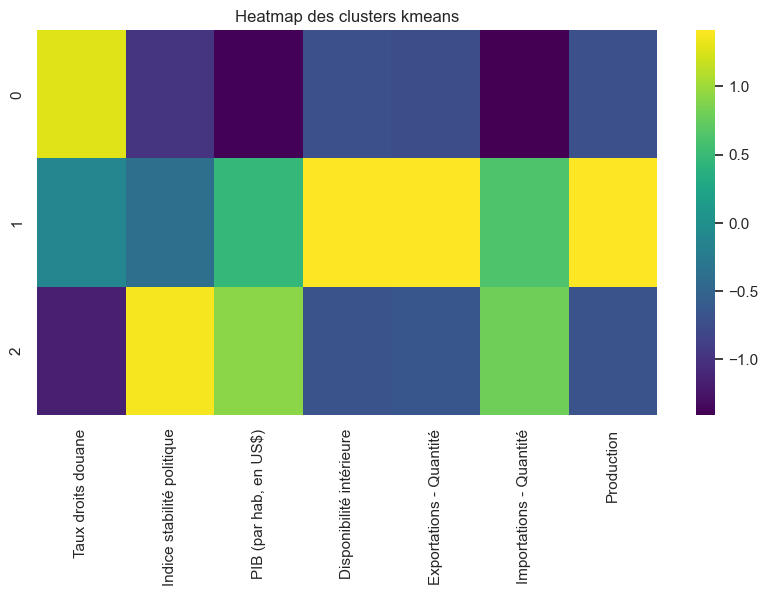

In [33]:
heat_clusters_graph_kmeans = StandardScaler().fit_transform(heat_clusters_kmeans)
plt.figure(figsize=(10,5))
plt.title('Heatmap des clusters kmeans')
sns.set(font_scale=1)
sns.heatmap(heat_clusters_graph_kmeans, cmap='viridis',xticklabels=heat_clusters_kmeans.columns, yticklabels=heat_clusters_kmeans.index)

# On voit que les 2 heatmap sont très similaire. sur cette heatmap on choisi le cluster 2.

In [34]:
K0 = df.loc[df['clusters_kmean'] == 0, :] 
K0.Zone.unique()

array(['Afghanistan', 'Angola', 'Albanie', 'Argentine', 'Arménie',
       'Antigua-et-Barbuda', 'Azerbaïdjan', 'Bénin', 'Burkina Faso',
       'Bangladesh', 'Bahamas', 'Bosnie-Herzégovine', 'Bélarus', 'Belize',
       'Bolivie (État plurinational de)', 'Barbade',
       'République centrafricaine', "Côte d'Ivoire", 'Cameroun', 'Congo',
       'Colombie', 'Cabo Verde', 'Cuba', 'Dominique',
       'République dominicaine', 'Algérie', 'Équateur', 'Égypte',
       'Éthiopie', 'Fidji', 'Gabon', 'Géorgie', 'Ghana', 'Guinée',
       'Gambie', 'Guinée-Bissau', 'Grenade', 'Guatemala', 'Guyana',
       'Honduras', 'Haïti', 'Indonésie', 'Inde',
       "Iran (République islamique d')", 'Jamaïque', 'Jordanie',
       'Kazakhstan', 'Kenya', 'Kirghizistan', 'Cambodge',
       'Saint-Kitts-et-Nevis', 'Liban', 'Libéria', 'Sainte-Lucie',
       'Sri Lanka', 'Lesotho', 'Maroc', 'Madagascar', 'Macédoine du Nord',
       'Mali', 'Myanmar', 'Monténégro', 'Mongolie', 'Mozambique',
       'Mauritanie', 'Malaw

In [36]:
K1 = df.loc[df['clusters_kmean'] == 1, :] 
K1.Zone.unique()

array(['Brésil', 'Chine, continentale', "États-Unis d'Amérique"],
      dtype=object)

In [37]:
K2 = df.loc[df['clusters_kmean'] == 2, :] 
K2 = K2.reset_index()
K2.Zone.unique()

# Quand on compare cette liste à la liste du cluster 3 de la méthode de classification hiérarchique, on constate qu'il y a un
    # grand nombre de pays similaires.
# On a + de pays avec kmeans, on décide donc de garder C3 pour faire l'ACP.

array(['Émirats arabes unis', 'Australie', 'Autriche', 'Belgique',
       'Bulgarie', 'Botswana', 'Canada', 'Suisse', 'Chili', 'Costa Rica',
       'Chypre', 'Tchéquie', 'Allemagne', 'Danemark', 'Espagne',
       'Estonie', 'Finlande', 'France',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Grèce',
       'Chine - RAS de Hong-Kong', 'Croatie', 'Hongrie', 'Irlande',
       'Islande', 'Israël', 'Italie', 'Japon', 'République de Corée',
       'Koweït', 'Lituanie', 'Luxembourg', 'Lettonie', 'Mexique', 'Malte',
       'Maurice', 'Pays-Bas', 'Norvège', 'Nouvelle-Zélande', 'Oman',
       'Pologne', 'Portugal', 'Roumanie', 'Arabie saoudite', 'Slovaquie',
       'Slovénie', 'Suède', 'Uruguay', 'Viet Nam', 'Afrique du Sud',
       'Chine - RAS de Macao'], dtype=object)

# 3. ACP sur le cluster choisi : 

## 3.1 Variance et Eboulis:

In [38]:
C3.head(2)

,Zone,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,clusters
3,Émirats arabes unis,3.28,0.63,53374.216781,412.0,94.0,433.0,48.0,3
7,Australie,0.71,0.85,64511.169763,1171.0,42.0,16.0,1269.0,3


In [39]:
C3_bis= C3
C3_bis.head()

,Zone,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,clusters
3,Émirats arabes unis,3.28,0.63,53374.216781,412.0,94.0,433.0,48.0,3
7,Australie,0.71,0.85,64511.169763,1171.0,42.0,16.0,1269.0,3
8,Autriche,1.48,0.85,52091.441177,173.0,78.0,110.0,148.0,3
10,Belgique,1.48,0.59,50318.280146,152.0,656.0,338.0,463.0,3
24,Canada,1.49,1.11,56180.555494,1433.0,163.0,182.0,1417.0,3


In [40]:
C3_bis.drop(columns='clusters',inplace=True)

C:\Users\leuriot\AppData\Local\Temp\ipykernel_900\3420535617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  C3_bis.drop(columns='clusters',inplace=True)


In [41]:
C3_bis = C3_bis.set_index('Zone')

In [42]:
C3_bis.head(2)

,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
Zone,,,,,,,
Émirats arabes unis,3.28,0.63,53374.216781,412.0,94.0,433.0,48.0
Australie,0.71,0.85,64511.169763,1171.0,42.0,16.0,1269.0


In [43]:
pays = C3_bis.index
pays

Index(['Émirats arabes unis', 'Australie', 'Autriche', 'Belgique', 'Canada',
       'Suisse', 'Allemagne', 'Danemark', 'Finlande', 'France',
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord',
       'Chine - RAS de Hong-Kong', 'Irlande', 'Islande', 'Japon', 'Luxembourg',
       'Mexique', 'Pays-Bas', 'Norvège', 'Nouvelle-Zélande', 'Arabie saoudite',
       'Suède', 'Afrique du Sud', 'Iraq'],
      dtype='object', name='Zone')

In [44]:
features = C3_bis.columns
features

Index(['Taux droits douane', 'Indice stabilité politique',
       'PIB (par hab, en US$)', 'Disponibilité intérieure',
       'Exportations - Quantité', 'Importations - Quantité', 'Production'],
      dtype='object')

In [45]:
# On scale nos données

scaler = StandardScaler()

In [46]:
# On instancie et on entraine notre scaler:

scaler.fit(C3_bis)

StandardScaler()

In [47]:
# On transforme les données:

C3_bis_scaled = scaler.transform(C3_bis)
C3_bis_scaled[:5]

array([[ 1.34104828,  0.0720313 , -0.04153386, -0.45650798, -0.34111879,
         0.18072462, -0.81974723],
       [-1.04647829,  0.32390235,  0.35534026,  0.27160246, -0.49586843,
        -1.00530289,  0.57427975],
       [-0.33114932,  0.32390235, -0.08724658, -0.68578123, -0.38873406,
        -0.73794897, -0.70557631],
       [-0.33114932,  0.02623657, -0.15043458, -0.70592658,  1.33136767,
        -0.0894735 , -0.3459379 ],
       [-0.32185933,  0.62156814,  0.05847224,  0.52293967, -0.13577793,
        -0.53316724,  0.74325271]])

In [48]:
#on confirme que la moyenne est à 0 et l'écart-type à 1:

idx = ["mean", "std"]

pd.DataFrame(C3_bis_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6
mean,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
std,1.02,1.02,1.02,1.02,1.02,1.02,1.02


In [49]:
# On défini le nombre de variables que l'on a:
n_components = 7

In [50]:
# On instancie l'ACP :
pca = PCA(n_components=n_components)

In [51]:
# On l'entraine sur les données scalées :
pca.fit(C3_bis_scaled)

PCA(n_components=7)

In [52]:
# On défini la variance captée par chaque nouvelle composante
pca.explained_variance_ratio_

array([0.49895691, 0.22614103, 0.14308638, 0.06079898, 0.04023616,
       0.02947067, 0.00130988])

In [53]:
# On enregistre cela dans une variable :
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([49.9 , 22.61, 14.31,  6.08,  4.02,  2.95,  0.13])

In [54]:
# On fait la somme cumulée des variances captées par les variables:
scree_cum = scree.cumsum().round()
scree_cum

# La variable 1 capte 50%, la variable 1 + la variable 2 captent 73%, etc.

array([ 50.,  73.,  87.,  93.,  97., 100., 100.])

In [55]:
# On défini une variable avec la liste de nos composantes :

x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7]

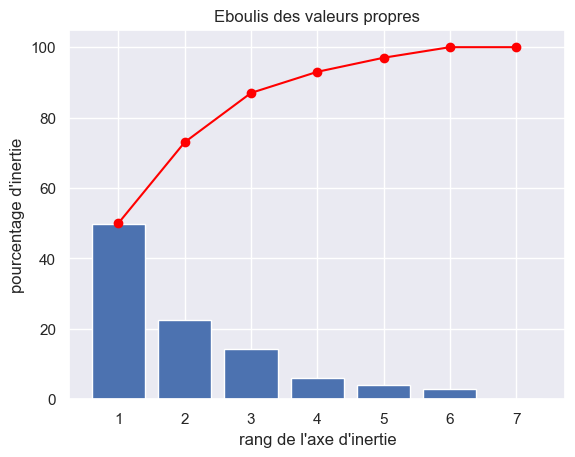

In [56]:
# On affiche l'éboulis:

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [ ]:
#En conservant les 4 premières composantes principales (= les deux premiers plans factoriels), on "capte" 93% des informations
    #présentes dans l'intégralité de nos 7 variables.
# Sur le premier plan factoriel on capte 73%

## 3.2 : Les Composantes principales

In [57]:
# Calcul des composantes:
pcs = pca.components_

In [58]:
# Version df:

pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6
0,0.186751,-0.371576,-0.450076,0.472273,0.074575,0.456184,0.433336
1,0.630387,-0.381176,-0.172170,-0.144878,-0.516321,-0.209164,-0.310399
2,0.130029,-0.320910,-0.156673,-0.415847,0.708247,0.201494,-0.374727
3,-0.732854,-0.457728,-0.365259,-0.076932,-0.249040,-0.147389,-0.174165
4,-0.101895,-0.421808,0.714926,0.092081,-0.180419,0.485202,-0.155324
5,-0.058031,0.468487,-0.313191,-0.149885,-0.313559,0.651049,-0.366625
6,-0.002041,-0.082076,0.024912,-0.739038,-0.182609,0.162902,0.621755


In [59]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
F1,0.19,-0.37,-0.45,0.47,0.07,0.46,0.43
F2,0.63,-0.38,-0.17,-0.14,-0.52,-0.21,-0.31
F3,0.13,-0.32,-0.16,-0.42,0.71,0.20,-0.37
F4,-0.73,-0.46,-0.37,-0.08,-0.25,-0.15,-0.17
F5,-0.10,-0.42,0.71,0.09,-0.18,0.49,-0.16
F6,-0.06,0.47,-0.31,-0.15,-0.31,0.65,-0.37
F7,-0.00,-0.08,0.02,-0.74,-0.18,0.16,0.62


In [60]:
x, y = 0,1

In [61]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [62]:
x_y = (0,1)
x_y

(0, 1)

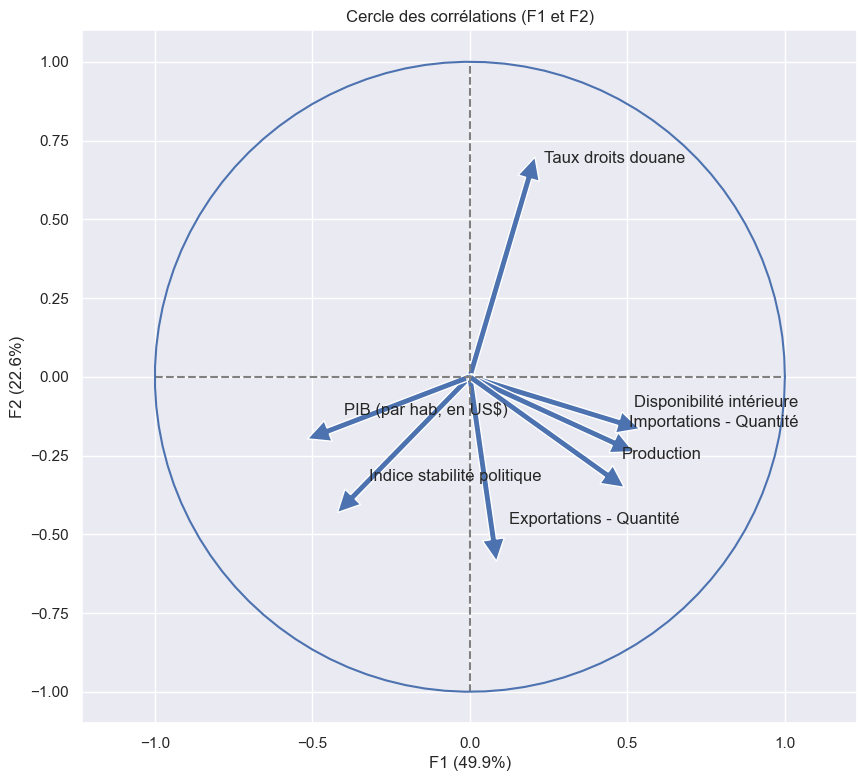

In [63]:
# le cercle des corrélations des deux premières composantes principales:

correlation_graph(pca, x_y, features)

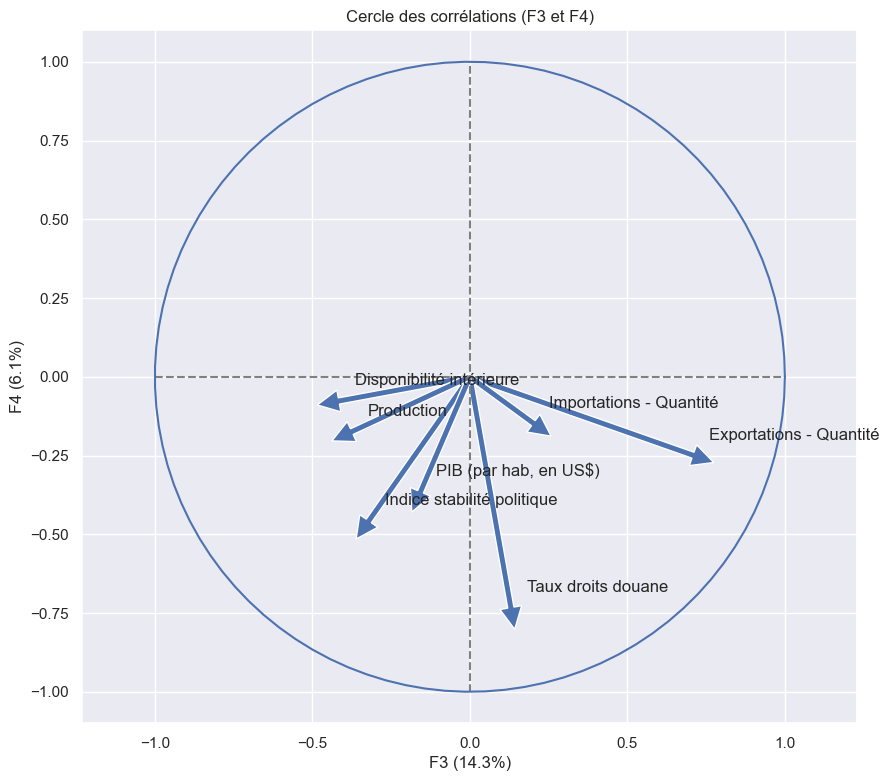

In [64]:
# le cercle des corrélations des composantes principales 3 et 4:

correlation_graph(pca, (2,3), features)

In [65]:
X_proj = pca.transform(C3_bis_scaled)
X_proj[:5]

array([[-0.27144683,  1.2839863 ,  0.449604  , -0.76438524,  0.03780041,
         0.56251635, -0.09025679],
       [-0.59417128, -0.59563396, -1.17759123,  0.63961205, -0.23845331,
        -0.64908956,  0.0675243 ],
       [-1.13818691,  0.35623437, -0.00776696,  0.50751387, -0.40673082,
         0.20120609, -0.0091863 ],
       [-0.4287113 , -0.65189842,  1.32018936,  0.08180521, -0.37976096,
        -0.16445277,  0.0436974 ],
       [-0.00168365, -0.5747333 , -0.95005326, -0.12727334, -0.48907259,
        -0.36385831, -0.03531357]])

In [66]:
x_y

(0, 1)

In [67]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

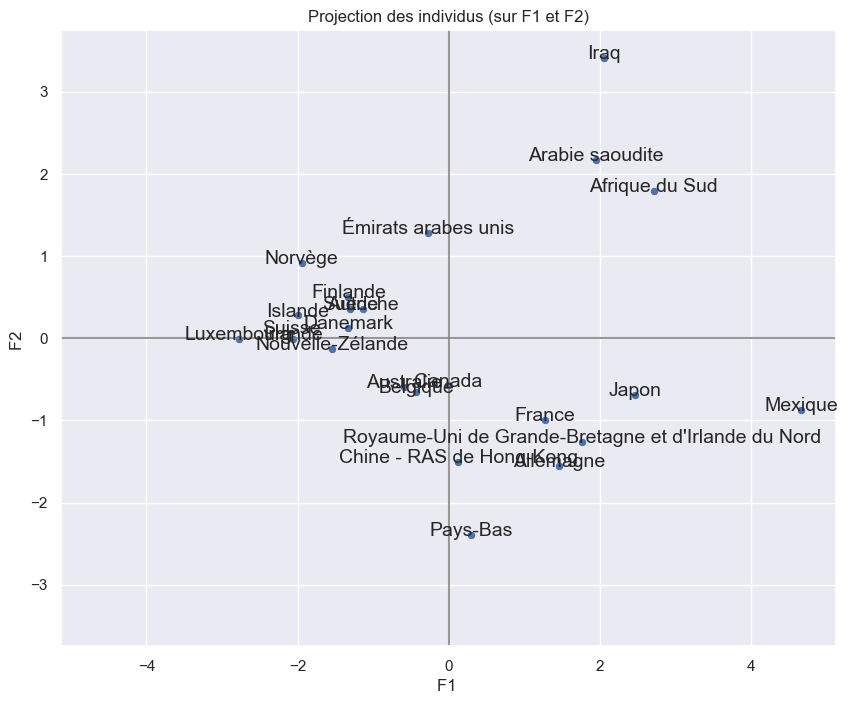

In [68]:
# projection du nuage des individus sur le premier plan factoriel:

x_y = [0,1]
display_factorial_planes(X_proj, x_y, labels=pays)

In [69]:
X_proj_df = pd.DataFrame(X_proj)

In [71]:
C3

,Zone,Taux droits douane,Indice stabilité politique,"PIB (par hab, en US$)",Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
3,Émirats arabes unis,3.280,0.63,53374.216781,412.0,94.0,433.0,48.0
7,Australie,0.710,0.85,64511.169763,1171.0,42.0,16.0,1269.0
8,Autriche,1.480,0.85,52091.441177,173.0,78.0,110.0,148.0
10,Belgique,1.480,0.59,50318.280146,152.0,656.0,338.0,463.0
24,Canada,1.490,1.11,56180.555494,1433.0,163.0,182.0,1417.0
25,Suisse,1.360,1.19,91827.314486,133.0,4.0,51.0,91.0
37,Allemagne,1.480,0.67,48107.866666,1739.0,646.0,842.0,1514.0
39,Danemark,1.480,0.94,64854.042111,167.0,139.0,133.0,173.0
47,Finlande,1.480,0.94,50532.376603,111.0,12.0,16.0,129.0
49,France,1.480,0.31,42769.227957,1573.0,501.0,506.0,1750.0


In [72]:
x_y = 2,3

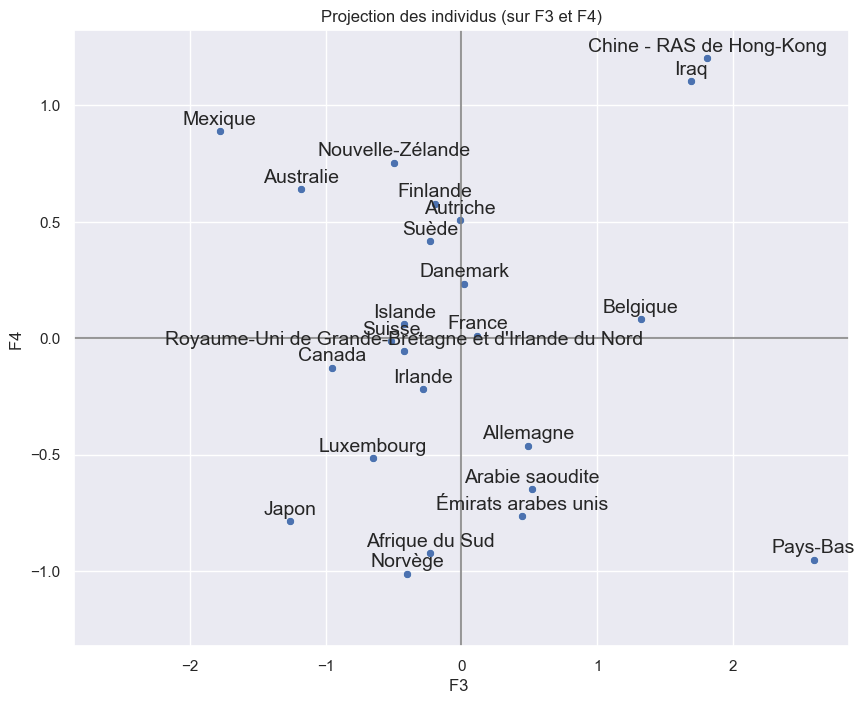

In [73]:
# projection du nuage des individus sur le deuxième plan factoriel:

display_factorial_planes(X_proj, x_y,labels=pays)

In [70]:
X_proj_df.columns = [f"F{i}" for i in x_list]
X_proj_df.index = pays
X_proj_df

,F1,F2,F3,F4,F5,F6,F7
Zone,,,,,,,
Émirats arabes unis,-0.271447,1.283986,0.449604,-0.764385,0.037800,0.562516,-0.090257
Australie,-0.594171,-0.595634,-1.177591,0.639612,-0.238453,-0.649090,0.067524
Autriche,-1.138187,0.356234,-0.007767,0.507514,-0.406731,0.201206,-0.009186
Belgique,-0.428711,-0.651898,1.320189,0.081805,-0.379761,-0.164453,0.043697
Canada,-0.001684,-0.574733,-0.950053,-0.127273,-0.489073,-0.363858,-0.035314
Suisse,-2.080257,0.068350,-0.518470,-0.012312,0.417672,-0.064037,-0.004857
Allemagne,1.463386,-1.550738,0.488159,-0.461323,0.179991,0.177604,-0.105887
Danemark,-1.328140,0.123217,0.021361,0.234850,-0.131016,0.083103,-0.006806
Finlande,-1.325567,0.499207,-0.192246,0.577317,-0.586305,0.171273,0.003755
